# Libraries

Here, the required packages are installed

In [ ]:
import sys
!conda config --append channels conda-forge
!conda install --yes --prefix {sys.prefix} xgboost
!{sys.executable} -m pip install numpy pandas matplotlib seaborn sklearn

Here, the required packages are imported

In [83]:
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

Here, some options are configured

In [10]:
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)

# Section 1. Data visualization

The dataset is loaded to a Pandas dataframe

In [21]:
db = pd.read_csv('./london_merged.csv')

### 1.1. Dataset - Attributes

In [22]:
db.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


timestamp ..... -> Indicates a specific date (yyyy-dd-mm) and time (hh:mm:ss). <br>
cnt ................. -> Indicates the number of shared bicycles at a specific time. <br>
t1 ................... -> Indicates the temperature in °C (real temperature). <br>
t2 ................... -> Indicates the thermal sensation (temperature feels like). <br>
hum ............... -> Indicates the humidity in percentage (%). <br>
wind_speed ... -> Indicates the wind speed in Km/h. <br>
weather_code -> Indicates the weather type according to a category. <br>
is_holiday ...... -> Indicates whether the day is a holiday or not. <br>
is_weekend ... -> Indicates whether the day is a weekend day or not. <br>
season .......... -> Indicates the season of the year. <br>

In [23]:
print('The total number of records in the dataset is: ' + str(db.timestamp.count()) + ', from: ' + str(db.timestamp.min()) + ' to: ' + str(db.timestamp.max()))

The total number of records in the dataset is: 17414, from: 2015-01-04 00:00:00 to: 2017-01-03 23:00:00


#### Numerical attributes

In [24]:
data = {'Attribute': ['cnt (#)','t1 (°C)','t2 (°C)','hum (%)','wind_speed (Km/h)'],
'Min value': [str(db.cnt.min()),db.t1.min(),db.t2.min(),db.hum.min(),db.wind_speed.min()],
'Max value': [str(db.cnt.max()),db.t1.max(),db.t2.max(),db.hum.max(),db.wind_speed.max()],
'Mean value': [db.cnt.mean(),db.t1.mean(),db.t2.mean(),db.hum.mean(),db.wind_speed.mean()]}

In [25]:
pd.DataFrame(data,columns=['Attribute', 'Min value', 'Max value', 'Mean value'])

,Attribute,Min value,Max value,Mean value
0,cnt (#),0,7860,1143.101642
1,t1 (°C),-1.5,34,12.468091
2,t2 (°C),-6,34,11.520836
3,hum (%),20.5,100,72.324954
4,wind_speed (Km/h),0,56.5,15.913063


#### Categorical attributes

In [26]:
data = {'Attribute': ['weather_code','is_holiday','is_weekend','season'],
'Values': [np.sort(db.weather_code.unique().astype(int)),np.sort(db.is_holiday.unique().astype(int)),np.sort(db.is_weekend.unique().astype(int)),np.sort(db.season.unique().astype(int))]}

In [27]:
pd.DataFrame(data,columns=['Attribute', 'Values'])

,Attribute,Values
0,weather_code,"[1, 2, 3, 4, 7, 10, 26]"
1,is_holiday,"[0, 1]"
2,is_weekend,"[0, 1]"
3,season,"[0, 1, 2, 3]"


### 1.2. Dataset - Count of shared bikes (cnt)

In [28]:
print('The minimum number of bikes shared at the same time is: ' + str(db.cnt.min()))
print('The maximum number of bikes shared at the same time is: ' + str(db.cnt.max()))
print('The mean number of bikes shared at the same time is: ' + str(db.cnt.mean()))

The minimum number of bikes shared at the same time is: 0
The maximum number of bikes shared at the same time is: 7860
The mean number of bikes shared at the same time is: 1143.1016423567244


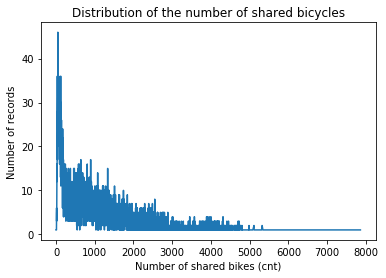

In [29]:
shared_bikes = db.groupby('cnt')['cnt'].count()
_ = shared_bikes.plot()

_ = plt.title('Distribution of the number of shared bicycles')
_ = plt.xlabel("Number of shared bikes (cnt)")
_ = plt.ylabel("Number of records")

In the above plot can be appreciated that, on certain occasions, a big number of bikes are being shared at the same time (more than 4,800 bikes). Such phenomena are very rare, and data related to them should be considered as outliers and should, therefore, be removed before training a model.

Before removing any data from the dataset, it should be determined if such anomalies are related to specific days or events (data analysis).

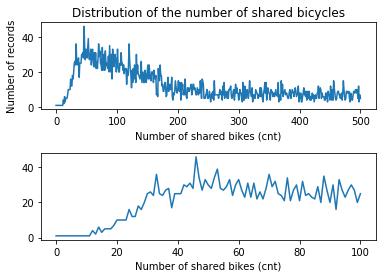

In [30]:
fig, (ax1, ax2) = plt.subplots(2, 1)

_ = shared_bikes.loc[0:500].plot(ax=ax1)
_ = ax1.xaxis.set_label_text("Number of shared bikes (cnt)")
_ = ax1.yaxis.set_label_text("Number of records")
_ = ax1.set_title("Distribution of the number of shared bicycles")

_ = shared_bikes.loc[0:100].plot(ax=ax2)
_ = ax2.xaxis.set_label_text("Number of shared bikes (cnt)")
_ = fig.subplots_adjust(hspace=0.5)

Zooming in on the graph above, it is possible to notice that the most common number of shared bikes is around 50.

### 1.3. Dataset - Temperature (t1)

In [31]:
print('The minimum temperature is: ' + str(db.t1.min()) + ' °C')
print('The maximum temperature is: ' + str(db.t1.max()) + ' °C')
print('The mean temperature is: ' + str(db.t1.mean()) + ' °C')

The minimum temperature is: -1.5 °C
The maximum temperature is: 34.0 °C
The mean temperature is: 12.468090808162016 °C


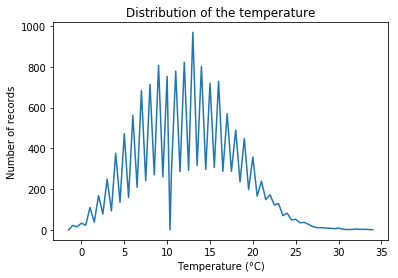

In [32]:
shared_bikes = db.groupby('t1')['t1'].count()
_ = shared_bikes.plot()

_ = plt.title('Distribution of the temperature')
_ = plt.xlabel("Temperature (°C)")
_ = plt.ylabel("Number of records")

The temperature in the records approximates a standard distribution, which is what would be expected from most of the variables.

### 1.4. Dataset - Thermal sensation (t2)

In [33]:
print('The minimum thermal sensation is: ' + str(db.t2.min()) + ' °C')
print('The maximum thermal sensation is: ' + str(db.t2.max()) + ' °C')
print('The mean thermal sensation is: ' + str(db.t2.mean()) + ' °C')

The minimum thermal sensation is: -6.0 °C
The maximum thermal sensation is: 34.0 °C
The mean thermal sensation is: 11.52083572604418 °C


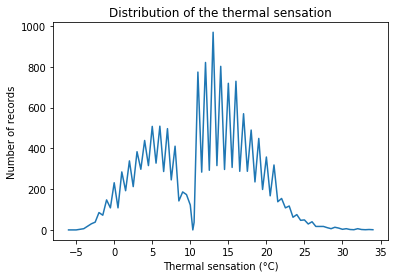

In [34]:
shared_bikes = db.groupby('t2')['t2'].count()
_ = shared_bikes.plot()

_ = plt.title('Distribution of the thermal sensation')
_ = plt.xlabel("Thermal sensation (°C)")
_ = plt.ylabel("Number of records")

As in the temperature distribution, thermal sensation records also approximate a standard distribution, except around 10 °C. However, a similar phenomenon can be seen in the temperature graph, so there is probably a relationship.

### 1.5. Dataset - Humidity (hum)

In [35]:
print('The minimum humidity percentage is: ' + str(db.hum.min()) + '%')
print('The maximum humidity percentage is: ' + str(db.hum.max()) + '%')
print('The mean humidity percentage is: ' + str(db.hum.mean()) + '%')

The minimum humidity percentage is: 20.5%
The maximum humidity percentage is: 100.0%
The mean humidity percentage is: 72.32495405995176%


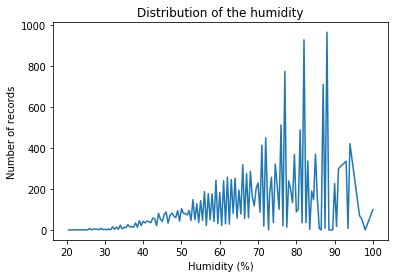

In [36]:
shared_bikes = db.groupby('hum')['hum'].count()
_ = shared_bikes.plot()

_ = plt.title('Distribution of the humidity')
_ = plt.xlabel("Humidity (%)")
_ = plt.ylabel("Number of records")

Not much can be infered from the humidity percentage graph, except that London is not a dry city. In the data analysis section, a comparison between the humidity and the number of shared bikes (cnt) should be done, in order to determine if the humidity in the weather affects the number of shared bikes.

### 1.6. Dataset - Wind speed

In [37]:
print('The minimum wind speed is: ' + str(db.wind_speed.min()) + ' Km/h')
print('The maximum wind speed is: ' + str(db.wind_speed.max()) + ' Km/h')
print('The mean wind speed is: ' + str(db.wind_speed.mean()) + ' Km/h')

The minimum wind speed is: 0.0 Km/h
The maximum wind speed is: 56.5 Km/h
The mean wind speed is: 15.913063244133076 Km/h


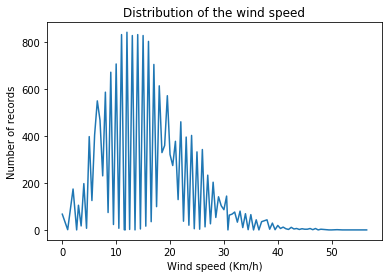

In [38]:
shared_bikes = db.groupby('wind_speed')['wind_speed'].count()
_ = shared_bikes.plot()

_ = plt.title('Distribution of the wind speed')
_ = plt.xlabel("Wind speed (Km/h)")
_ = plt.ylabel("Number of records")

Similarly to the temperature, the wind speed graph approximates a standard distribution. A couple of cases of very high speed can be appreciated. It would be interesting to observe the relation between the number of bikes and high wind speeds, however, in contrast to cnt outliers, wind speed outliers do not affect the predictive model in a negative way, on the contrary, such data are very important to obtain more accurate predictions.

### 1.7. Dataset - Weather

In [39]:
print('The weather codes are: ' + str(np.sort(db.weather_code.unique().astype(int))))

The weather codes are: [ 1  2  3  4  7 10 26]


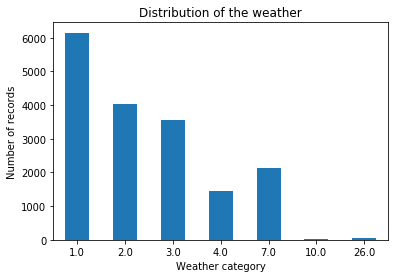

In [40]:
shared_bikes = db.groupby('weather_code')['weather_code'].count()
_ = shared_bikes.plot.bar(rot=0, color='#1f77b4')

_ = plt.title('Distribution of the weather')
_ = plt.xlabel("Weather category")
_ = plt.ylabel("Number of records")

There are a total of 7 different kinds of weather, the most common of them is 1, while 10 and 26 rarely occur. This could be a hint of very unusual weather, such as snow or thunderstorm.

### 1.8. Dataset - Holiday

In [41]:
print('In the case of "holiday" there are just two possible values: "Is holiday" (1) and "Is not holiday" (0)')

In the case of "holiday" there are just two possible values: "Is holiday" (1) and "Is not holiday" (0)


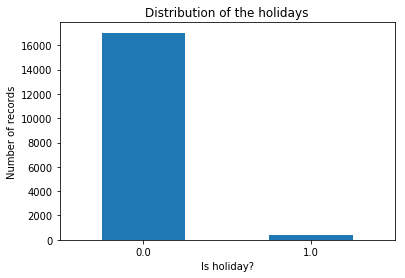

In [42]:
shared_bikes = db.groupby('is_holiday')['is_holiday'].count()
_ = shared_bikes.plot.bar(rot=0, color='#1f77b4')

_ = plt.title('Distribution of the holidays')
_ = plt.xlabel("Is holiday?")
_ = plt.ylabel("Number of records")

It can be seen that really few days correspond to holidays, which is quite logical.

### 1.9. Dataset - Weekend

In [43]:
print('In the case of "weekend" there are just two possible values: "Is weekend" (1) and "Is not weekend" (0)')

In the case of "weekend" there are just two possible values: "Is weekend" (1) and "Is not weekend" (0)


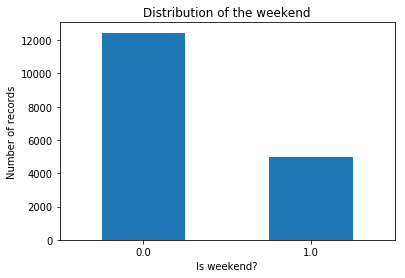

In [44]:
shared_bikes = db.groupby('is_weekend')['is_weekend'].count()
_ = shared_bikes.plot.bar(rot=0, color='#1f77b4')

_ = plt.title('Distribution of the weekend')
_ = plt.xlabel("Is weekend?")
_ = plt.ylabel("Number of records")

It can be seen that weekends correspond to about one-third of the total of days, just as can be expected.

### 1.10. Dataset - Season

In [45]:
print('The season codes are: ' + str(np.sort(db.season.unique().astype(int))) + ', that correspond to 4 seasons of the year.')

The season codes are: [0 1 2 3], that correspond to 4 seasons of the year.


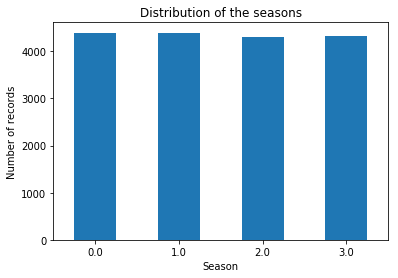

In [46]:
shared_bikes = db.groupby('season')['season'].count()
_ = shared_bikes.plot.bar(rot=0, color='#1f77b4')

_ = plt.title('Distribution of the seasons')
_ = plt.xlabel("Season")
_ = plt.ylabel("Number of records")

Finally, each of the seasons corresponds to exactly a quarter of the total number of days.

# Section 2. Data analysis

### 2.1. Dataset - Null values per column

In [47]:
db.isna().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

There are not empty values in the dataset.

### 2.2. Dataset - Count of shared bikes (cnt) by date

Previously, in section 1.2, some outliers could be seen in the count of shared bikes (cnt) distribution. Let's analyze if such outliers are related to events occurred during specific days.

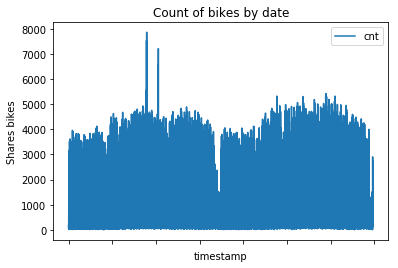

In [48]:
db.plot(x='timestamp',y='cnt')
plt.title('Count of bikes by date')
plt.ylabel('Shares bikes')
plt.show()

On the graph above, positive and negative outliers are very clear, and they seem to be, in fact, related to specific dates. Let's check the records with the highest values of shared bikes.

In [49]:
db[db.cnt > 4000].sort_values(by=['cnt'])

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
12069,2016-05-23 18:00:00,4001,18.0,18.0,50.5,17.0,2.0,0.0,0.0,0.0
4134,2015-06-25 17:00:00,4002,24.0,24.0,44.0,12.0,2.0,0.0,0.0,1.0
5465,2015-08-20 08:00:00,4002,18.0,18.0,88.0,11.0,3.0,0.0,0.0,1.0
12453,2016-06-08 18:00:00,4007,22.5,22.5,67.0,3.5,2.0,0.0,0.0,1.0
8915,2016-01-12 08:00:00,4007,5.0,0.0,81.0,29.0,2.0,0.0,0.0,3.0
4149,2015-06-26 08:00:00,4009,19.5,19.5,49.0,7.0,1.0,0.0,0.0,1.0
6153,2015-09-18 08:00:00,4009,14.5,14.5,85.0,9.0,3.0,0.0,0.0,2.0
3442,2015-05-27 18:00:00,4010,18.0,18.0,50.5,27.0,1.0,0.0,0.0,0.0
13679,2016-07-30 13:00:00,4012,21.0,21.0,51.5,10.0,2.0,0.0,1.0,1.0
5978,2015-09-10 17:00:00,4013,18.5,18.5,62.0,27.0,2.0,0.0,0.0,2.0


Observing the previous table, one can notice that the records with the highest ranges of shared bikes are related to specific times of the day (7:00 - 8:00 am, 17:00 - 18:00 pm), probably the times when Londoners usually go to school/work and back home.

The seven records with the highest ranges of shared bikes, are pretty far from the rest of the records. Paying attention to them, is possible to notice that all are related to two specific dates (2015-07-09 and 2015-08-06). Googling the dates and "London", one may find that on both dates, the London underground was shut down by strikes (https://www.youtube.com/watch?v=2gm4yTUe84g, https://www.bbc.com/news/live/uk-england-london-33674627).

It would be convenient to remove all of the records from both dates, as they would be outliers for the Machine Learning (ML) model.

In [50]:
db.sort_values(by=['cnt']).head(500)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
2015,2015-03-29 01:00:00,0,10.5,8.5,77.0,33.0,7.0,0.0,1.0,0.0
16361,2016-11-21 03:00:00,9,6.0,3.5,93.0,12.0,7.0,0.0,0.0,2.0
17393,2017-01-03 03:00:00,10,0.0,-4.0,93.0,13.0,1.0,0.0,0.0,3.0
11070,2016-04-12 03:00:00,11,9.0,7.0,87.0,14.0,7.0,0.0,0.0,0.0
9575,2016-02-09 03:00:00,12,6.0,2.0,71.0,24.0,3.0,0.0,0.0,3.0
9743,2016-02-16 03:00:00,12,0.5,-0.5,90.0,5.0,1.0,0.0,0.0,3.0
12798,2016-06-23 03:00:00,12,19.0,19.0,94.0,8.0,7.0,0.0,0.0,1.0
9293,2016-01-28 02:00:00,12,6.5,3.5,68.5,19.5,1.0,0.0,0.0,3.0
218,2015-01-13 03:00:00,13,11.0,11.0,85.0,19.0,7.0,0.0,0.0,3.0
11766,2016-05-11 03:00:00,13,15.0,15.0,94.0,8.0,7.0,0.0,0.0,0.0


The pattern is not evident by just observing the previous table. It would be necessary to make an analysis by month and day (separating the timestamp attribute) and excluding the time.

In [51]:
shared_bikes = db
shared_bikes['timestamp'] = pd.to_datetime(shared_bikes['timestamp'], format ="%Y-%m-%d %H:%M:%S")
shared_bikes['day']=shared_bikes['timestamp'].dt.date
shared_bikes['month']=shared_bikes['timestamp'].dt.month
shared_bikes = shared_bikes.groupby(['day','month','is_holiday','is_weekend'], as_index=False)['cnt'].sum()

mean_day = shared_bikes.cnt.mean()

print('The mean of shared bikes per day is: ' + str(mean_day))

The mean of shared bikes per day is: 27268.45479452055


In [52]:
shared_bikes[shared_bikes.cnt < mean_day][['day','month','cnt','is_holiday','is_weekend']].sort_values(by=['cnt'])

,day,month,cnt,is_holiday,is_weekend
364,2016-01-03,1,4869,0.0,1.0
727,2017-01-01,1,6421,0.0,1.0
363,2016-01-02,1,7195,0.0,1.0
719,2016-12-24,12,7890,0.0,1.0
448,2016-03-27,3,8123,0.0,1.0
84,2015-03-29,3,8592,0.0,1.0
314,2015-11-14,11,8898,0.0,1.0
354,2015-12-24,12,8908,0.0,0.0
677,2016-11-12,11,8990,0.0,1.0
49,2015-02-22,2,9086,0.0,1.0


Apparently, the low ranges of shared bikes are very common during the lasts and the firsts weekends and holidays of the year. This explains the negative outliers, which should be actually considered during the predictive model trainig.

It would be highly recommended to separate the "timestamp" column from the dataset into three different attributes: day, month, and time. Furthermore, a fourth attribute can be calculated from the timestamp, this is the day of the week (Monday-Sunday), which could improve the results of the ML models.

In [53]:
shared_bikes = db
shared_bikes['timestamp'] = pd.to_datetime(shared_bikes['timestamp'], format ="%Y-%m-%d %H:%M:%S")
shared_bikes['day']=shared_bikes['timestamp'].dt.date
shared_bikes['time']=shared_bikes['timestamp'].dt.time
shared_bikes = shared_bikes.groupby('day', as_index=False)['time'].count()
shared_bikes[shared_bikes.time < 24]

,day,time
3,2015-01-07,23
37,2015-02-10,23
84,2015-03-29,23
86,2015-03-31,20
90,2015-04-04,23
152,2015-06-05,21
190,2015-07-13,23
197,2015-07-20,21
250,2015-09-11,22
251,2015-09-12,18


If we count the total of records per day, we will notice that not all of the days have the 24 records corresponding to the 24 hours of a day (see the table above). This could have affected the previous analyzes, and will probably affect the models' training. Nevertheless, the missing records are so few that the impact on the models will be minimal.

### 2.3. Dataset - Comparison between shared bikes (cnt) and temperature (t1)

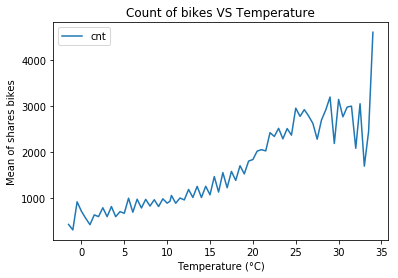

In [54]:
shared_bikes = db
shared_bikes = shared_bikes.groupby('t1', as_index=False)['cnt'].mean()

shared_bikes.plot(x='t1',y='cnt')
plt.title('Count of bikes VS Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Mean of shares bikes')
plt.show()

Taking the mean of shared bikes at different temperature records, seems to show a positive correlation between both attributes. Calculating the correlation between the number of shared bikes and the temperature, would be useful to prove such s hypothesis.

### 2.4. Dataset - Comparison between shared bikes (cnt) and thermal sensation (t2)

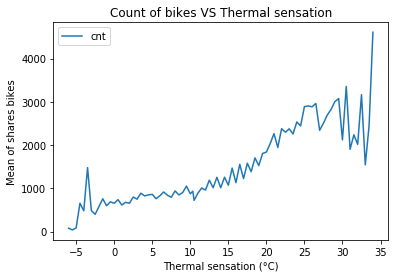

In [55]:
shared_bikes = db
shared_bikes = shared_bikes.groupby('t2', as_index=False)['cnt'].mean()

shared_bikes.plot(x='t2',y='cnt')
plt.title('Count of bikes VS Thermal sensation')
plt.xlabel('Thermal sensation (°C)')
plt.ylabel('Mean of shares bikes')
plt.show()

Thermal sensation obtains a postive correlation very similar to those of the temperature, and that occurs because thermal sensation and temperature are practically the same attribute.

### 2.5. Dataset - Comparison between shared bikes (cnt) and humidity (hum)

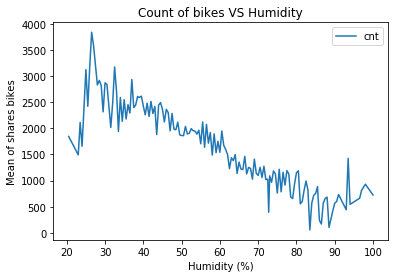

In [56]:
shared_bikes = db
shared_bikes = shared_bikes.groupby('hum', as_index=False)['cnt'].mean()

shared_bikes.plot(x='hum',y='cnt')
plt.title('Count of bikes VS Humidity')
plt.xlabel('Humidity (%)')
plt.ylabel('Mean of shares bikes')
plt.show()

In contrast to the temperature, the humidity gets a negative correlation with the number of shared bikes, which means that the higher humidity, the less shared bikes. This is probably related to rain, because nobody wants to get wet while riding a bicycle.

### 2.6. Dataset - Comparison between shared bikes (cnt) and wind speed

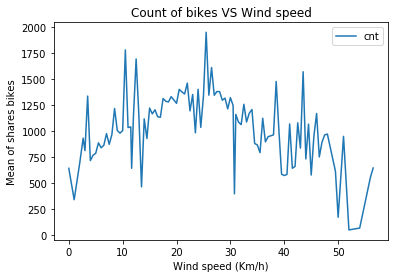

In [57]:
shared_bikes = db
shared_bikes = shared_bikes.groupby('wind_speed', as_index=False)['cnt'].mean()

shared_bikes.plot(x='wind_speed',y='cnt')
plt.title('Count of bikes VS Wind speed')
plt.xlabel('Wind speed (Km/h)')
plt.ylabel('Mean of shares bikes')
plt.show()

There is not a clear correlation between the number of shared bikes and wind speed. Apparently, as wind speed drops, so does the number of shared bikes, and exactly the same happens as wind speed increases. Maybe a high correlation value can be found by a non-linear correlation method (such as Spearman).

### 2.7. Dataset - Comparison between shared bikes (cnt) and weather

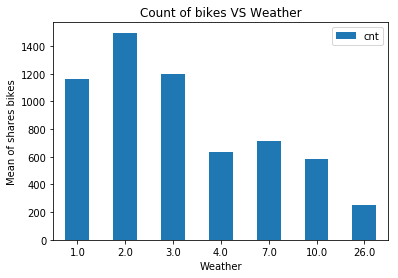

In [58]:
shared_bikes = db
shared_bikes = shared_bikes.groupby('weather_code', as_index=False)['cnt'].mean()

shared_bikes.plot(x='weather_code', y='cnt', kind='bar', rot=0, color='#1f77b4')
plt.title('Count of bikes VS Weather')
plt.xlabel('Weather')
plt.ylabel('Mean of shares bikes')
plt.show()

A correlation between the weather and the number of shared bikes is not clear. However, the last four types of weather, which have much lower shared bikes means than the other types of weather, are probably those with higher humidity and/or lower temperature.

### 2.8. Dataset - Comparison between shared bikes (cnt) and holidays

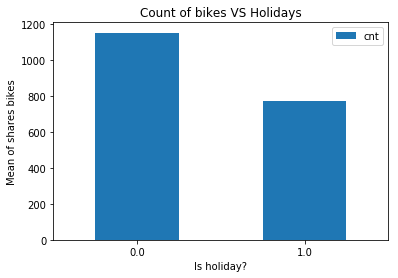

In [59]:
shared_bikes = db
shared_bikes = shared_bikes.groupby('is_holiday', as_index=False)['cnt'].mean()

shared_bikes.plot(x='is_holiday', y='cnt', kind='bar', rot=0, color='#1f77b4')
plt.title('Count of bikes VS Holidays')
plt.xlabel('Is holiday?')
plt.ylabel('Mean of shares bikes')
plt.show()

It is clear that the number of shared bikes is lower during holidays than normal days.

### 2.9. Dataset - Comparison between shared bikes (cnt) and weekends

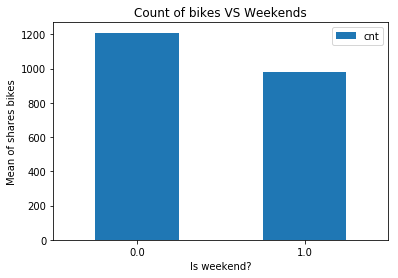

In [60]:
shared_bikes = db
shared_bikes = shared_bikes.groupby('is_weekend', as_index=False)['cnt'].mean()

shared_bikes.plot(x='is_weekend', y='cnt', kind='bar', rot=0, color='#1f77b4')
plt.title('Count of bikes VS Weekends')
plt.xlabel('Is weekend?')
plt.ylabel('Mean of shares bikes')
plt.show()

As in the case of the holidays, the number of shared bikes is lower during weekends than during week days. In spite of it, the difference is lower between weekends and week days than that of holidays and normal days.

### 2.10. Dataset - Comparison between shared bikes (cnt) and seasons

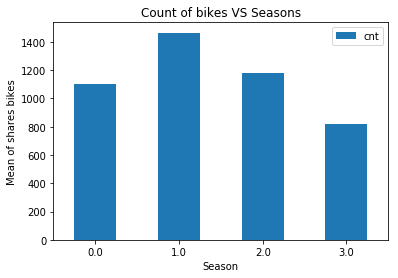

In [61]:
shared_bikes = db
shared_bikes = shared_bikes.groupby('season', as_index=False)['cnt'].mean()

shared_bikes.plot(x='season', y='cnt', kind='bar', rot=0, color='#1f77b4')
plt.title('Count of bikes VS Seasons')
plt.xlabel('Season')
plt.ylabel('Mean of shares bikes')
plt.show()

The last season (3) is the one with the lowest range of shared bikes. As the number of shared bikes is negatively correlated with the humidity, and postively correlated with the temperature, such season could be winter. This way, the season with the highest range of shared bikes (1) could be summer.

### 2.11. Dataset - Correlation between attributes

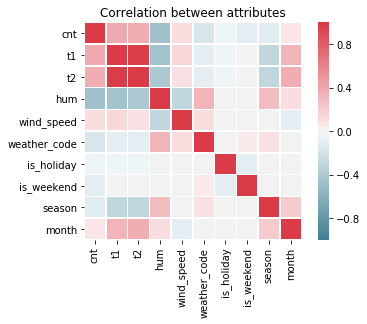

In [62]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
_ = sns.heatmap(db.corr(), cmap=cmap, vmax=1.0, vmin=-1.0, center=0, square=True, linewidths=.5)
_ = plt.title('Correlation between attributes')

As can be appreciated in the correlation matrix, the observations made above are correct. The number of shared bikes (cnt) correlates positively with temperature (t1) and negatively with humidity (hum).

Thermal sensation (t2) is strongly correlated to temperature (t1), which could provoke overfitting on the predictive models. It is recommended to remove one of those attributes before training a model. Moreover, something similar could happen between temperature and humidity. In case the models overfit, it would be a good idea to remove one of such attributes too.

# Section 3. Data treatment

In [11]:
db = pd.read_csv('./london_merged.csv')

### 3.1. Adding attributes

Separating the "timestamp" attribute into a date, time, day of the week, and month could improve the results of the predictive model, as we are adding important information to the dataset. Furthermore, I consider that removing the year from the date would be a good practice, as years do not occur again anymore, and it would be meaningless to train a predictive model with such information.

It is important to notice that "day_of_the_week" and "is_weekend" are strongly correlated, which could induce overfitting. It is recommended to remove the attribute is_weekend, as day_of_the_week contributes more information about the problem.

In [12]:
db['timestamp'] = pd.to_datetime(db['timestamp'], format ="%Y-%m-%d %H:%M:%S")
db['day'] = pd.to_numeric(db['timestamp'].dt.strftime('%d'))
db['month'] = db['timestamp'].dt.month
db['hour'] = db['timestamp'].dt.hour
db['day_of_week'] = db['timestamp'].dt.dayofweek
db.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,day,month,hour,day_of_week
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,4,1,0,6
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,4,1,1,6
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,4,1,2,6
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,4,1,3,6
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,1,4,6


In addition to the attributes above, the logarithm of the number of shared bikes (cnt) is calculated, in order to obtain a variable that describes a "more Gaussian" distribution.

In [13]:
db['cnt_log'] = np.log1p(db['cnt'])

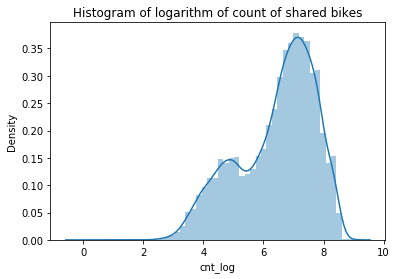

In [14]:
sns.distplot(db['cnt_log'])
plt.title("Histogram of logarithm of count of shared bikes")
_ = plt.ylabel('Density')

### 3.2. Removing outliers

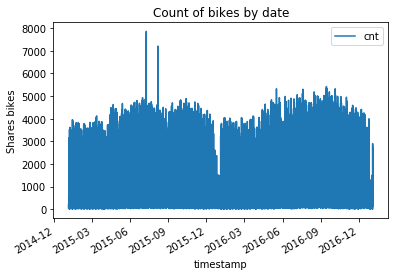

In [15]:
db.plot(x='timestamp',y='cnt')
plt.title('Count of bikes by date')
plt.ylabel('Shares bikes')
plt.show()

In [16]:
date_start = '2015-07-09 00:00:00'
date_end = '2015-07-09 23:00:00'
db = db[(db['timestamp'] < date_start) | (db['timestamp'] > date_end)]

date_start = '2015-08-06 00:00:00'
date_end = '2015-08-06 23:00:00'
db = db[(db['timestamp'] < date_start) | (db['timestamp'] > date_end)]

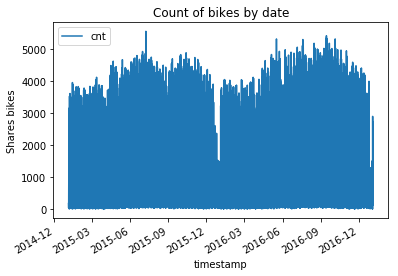

In [17]:
db.plot(x='timestamp',y='cnt')
plt.title('Count of bikes by date')
plt.ylabel('Shares bikes')
plt.show()

Now that dates 2015-07-09 and 2015-08-06 have been removed from the dataframe, the values on the graph look more uniform. Nevertheless, some outliers still present on the data. Such outliers will not be analyzed because of reasons of time.

### 3.3. One-hot encoding

As we don't know which code corresponds to which season, neither which code corresponds to which weather, hot-encoding both attributes would be the best option. The models could be trained both using one-hot encoding and without one-hot encoding, to determine which option gives better results.

In [18]:
db['weather_code'] = pd.Categorical(db['weather_code'])
db['season'] = pd.Categorical(db['season'])

weather_code = pd.get_dummies(db['weather_code'], prefix = 'weather')
season = pd.get_dummies(db['season'], prefix = 'season')

db = pd.concat([db, weather_code], axis=1)
db = pd.concat([db, season], axis=1)

### 3.4. Removing redundant data

In [19]:
db = db.drop(['t2','is_weekend','cnt','timestamp','weather_code','season'], axis = 1)
db.head()

,t1,hum,wind_speed,is_holiday,day,month,hour,day_of_week,cnt_log,weather_1.0,weather_2.0,weather_3.0,weather_4.0,weather_7.0,weather_10.0,weather_26.0,season_0.0,season_1.0,season_2.0,season_3.0
0,3.0,93.0,6.0,0.0,4,1,0,6,5.209486,0,0,1,0,0,0,0,0,0,0,1
1,3.0,93.0,5.0,0.0,4,1,1,6,4.934474,1,0,0,0,0,0,0,0,0,0,1
2,2.5,96.5,0.0,0.0,4,1,2,6,4.905275,1,0,0,0,0,0,0,0,0,0,1
3,2.0,100.0,0.0,0.0,4,1,3,6,4.290459,1,0,0,0,0,0,0,0,0,0,1
4,2.0,93.0,6.5,0.0,4,1,4,6,3.871201,1,0,0,0,0,0,0,0,0,0,1


By removing the attributes above, it is expected to avoid, or at least reduce, overfitting during the training phase.

# Section 4. Predictive models

### 4.1. Data splitting

#### Data (x) and targets (y) are splitted

In [20]:
x = db.drop(['cnt_log'], axis=1)
y = db['cnt_log']

#### Attributes in data (x) are scaled

In [21]:
scaler = preprocessing.MinMaxScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns = x.columns)

#### The index corresponding to the training percent of the data is obtained

In [22]:
train_percent = 0.7
split_index = int(train_percent * len(db))

#### Data (x) and targets (y) for training and test phases are obtained

In [23]:
x_train = x.iloc[:split_index]
x_test = x.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

In this case, data was not shuffled before splitting into training and test sets, insted, the last 30% of the data (ordered by date) was taken for the test set, this is because the predictive models train with current data and try to predict behavior from future observations.

### 4.2. Scoring metric

In [24]:
def rmsle(y, y_pred):
    
    assert(y.shape == y_pred.shape)
    y = np.expm1(y)
    y_pred=y_pred.clip(min=0)
    y_pred=y_pred.clip(max=10)
    y_pred = np.expm1(y_pred)
    return np.sqrt(mean_squared_log_error( y, y_pred))

In [44]:
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)
tscv = TimeSeriesSplit(n_splits=5)

This metric will help to reduce the impact of the outliers

### 4.3. Choosing the best classifiers (cross-validation)

In [31]:
def test_algorithms():
    
    names = ["LinearRegression", "Random Forrest", "XGBoost", "SVR" , "AdaBoost",
             "BaggingRegressor"]
    
    regressors = [
        LinearRegression(),
        RandomForestRegressor(random_state=42),
        XGBRegressor(objective ='reg:squarederror',random_state=42),
        SVR(),
        AdaBoostRegressor(random_state=42),
        BaggingRegressor(random_state=42)    
        ]
    
    reg_columns=['algorithm','score_rmsle_mean','score_std','time']
    reg_performance = pd.DataFrame(columns=reg_columns)
    print('Please wait 1-2 minutes for all algorithms to complete.')
    
    for name, regressor in zip(names, regressors):
        time_start = time.time()
        cv_results = cross_val_score(regressor, x_train, y_train, cv=5 ,scoring = rmsle_scorer)
        time_end = round(time.time() - time_start,3)
        mean_score = round(-cv_results.mean(),4)
        std_score = round(cv_results.std(),4)
        t= pd.DataFrame([[name,mean_score,std_score,time_end]],columns = reg_columns)
        reg_performance = reg_performance.append(t, ignore_index=True)
        print(name , ' RMSLE = ',mean_score , 'with std=',std_score ," execution_time =  ", time_end,"s")
    return reg_performance

reg_performance = test_algorithms()
reg_performance

Please wait 1-2 minutes for all algorithms to complete.
LinearRegression  RMSLE =  0.932 with std= 0.0622  execution_time =   0.042 s
Random Forrest  RMSLE =  0.2838 with std= 0.0552  execution_time =   1.77 s
XGBoost  RMSLE =  0.3528 with std= 0.0488  execution_time =   5.577 s
SVR  RMSLE =  0.8744 with std= 0.0596  execution_time =   20.945 s
AdaBoost  RMSLE =  0.5696 with std= 0.0308  execution_time =   2.632 s
BaggingRegressor  RMSLE =  0.2827 with std= 0.0543  execution_time =   1.782 s


,algorithm,score_rmsle_mean,score_std,time
0,LinearRegression,0.9320,0.0622,0.042
1,Random Forrest,0.2838,0.0552,1.770
2,XGBoost,0.3528,0.0488,5.577
3,SVR,0.8744,0.0596,20.945
4,AdaBoost,0.5696,0.0308,2.632
5,BaggingRegressor,0.2827,0.0543,1.782


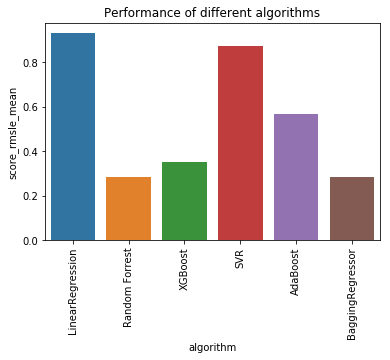

In [36]:
sns.barplot(data=reg_performance, x='algorithm', y='score_rmsle_mean')
plt.title('Performance of different algorithms')
_ = plt.xticks( rotation='vertical')

As can be seen in the graph and table above, those classifiers with the best performance (lower error) are Random Forest and BaggingRegressor, for that reason such classifiers will be selected to perform a grid search that optimize their parameters' values. 

### 4.4. Optimization of parameters (Grid search)

In [52]:
print('Please wait while the grid search is performed. This can take several minutes')

# ---------------------------------------------------------------------------------------------- #
# --------------------------------------- Random Forest ---------------------------------------- #

grid_values_rf = {'n_estimators': [10,100,500,750,1000,1200],
                  'max_depth' : [5,7,8,9],
                  'min_samples_leaf': [5,10,25,50],
                  'max_features': ['auto', 'sqrt'],
                 }

grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid = grid_values_rf,cv=tscv,scoring = rmsle_scorer)
grid_rf.fit(x_train, y_train)
#save_pickle(grid_rf.best_estimator_)_
#pd.DataFrame(grid_rf.cv_results_).to_csv('RF_cs_results.csv')


# ---------------------------------------------------------------------------------------------- #
# ------------------------------------- Baggring Regressor ------------------------------------- #
    
grid_values_br = {'n_estimators':[10,100,500,1000]}

grid_br = GridSearchCV(BaggingRegressor(random_state=42) , param_grid = grid_values_br,cv=tscv,scoring = rmsle_scorer)
grid_br.fit(x_train, y_train)
#save_pickle(grid_br.best_estimator_)
#pd.DataFrame(grid_br.cv_results_).to_csv('BR_cv_results.csv')

Please wait while the grid search is performed. This can take several minutes


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
         verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(rmsle, greater_is_better=False), verbose=0)

In [61]:
def convert_df(df,name):

    test_set = set(['rank_test_score','split0_test_score','split1_test_score','split2_test_score',
                   'split3_test_score','split4_test_score'])
    
    t = df[df['rank_test_score']==1][['split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score']]
    t = -t.T
    t=t.reset_index()
    t.columns=['algorithm','RMSLE_score']
    t.algorithm = name
    return t

clean = convert_df(pd.DataFrame(grid_rf.cv_results_),'RandomForest')
clean = clean.append(convert_df(pd.DataFrame(grid_br.cv_results_),'BaggingRegressor'))
clean

,algorithm,RMSLE_score
0,RandomForest,0.471752
1,RandomForest,0.294199
2,RandomForest,0.297367
3,RandomForest,0.385995
4,RandomForest,0.251491
0,BaggingRegressor,0.458077
1,BaggingRegressor,0.255891
2,BaggingRegressor,0.291850
3,BaggingRegressor,0.359612
4,BaggingRegressor,0.225944


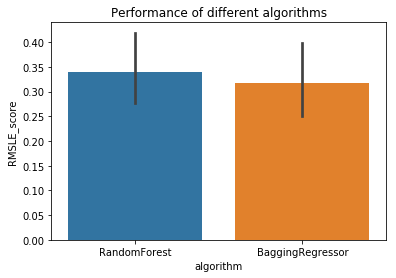

In [65]:
sns.barplot(data=clean, x='algorithm',y='RMSLE_score')
plt.title('Performance of different algorithms')
_ = plt.xticks(rotation=0)

Just as before the grid search, the BaggingRegressor still performing better than the Random Forest algorithm. Both classifiers reduced their RMSLE as can be seen in the table above.

### 4.5. Most relevant features

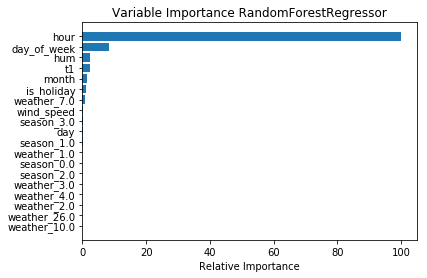

In [74]:
def plot_importance(model):

    feature_importance = model.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, x_train.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title(f'Variable Importance {model.__class__.__name__}')
    plt.show()

plot_importance(grid_rf.best_estimator_)

In the case of the Random Forest classifier, we can plot the importance of each feature for the classification (see the graph above). In the case of the Bagging Regressor, it is not possible to plot the features' importance as it can be used with many base estimators.

# Section 5. Results

### 5.1. Test set

In [75]:
def plot_scores(model,X_train,y_train):

    assert(y_train.shape[0] == X_train.shape[0])
    
    print("Model parameters ", model.__class__.__name__)
    prediction_train = np.expm1((model.predict(X_train).clip(min=0)))
    y_train = np.expm1(y_train)
    print("Root Mean Squared Error: " + str(np.sqrt(mean_squared_error(y_train, prediction_train))))
    print("Mean Absolute Error: " + str(mean_absolute_error(y_train, prediction_train)))
    print("R^2 Coefficient of Determination: " + str(r2_score(y_train, prediction_train)))
    print('RMSLE:', np.sqrt(mean_squared_log_error(y_train, prediction_train)))
    

In [84]:
plot_scores(grid_rf.best_estimator_, x_test, y_test)

Model parameters  RandomForestRegressor
Root Mean Squared Error: 409.18065367439436
Mean Absolute Error: 242.7022153823589
R^2 Coefficient of Determination: 0.8770735613063348
RMSLE: 0.3041628295653135


In [85]:
plot_scores(grid_br.best_estimator_, x_test, y_test)

Model parameters  BaggingRegressor
Root Mean Squared Error: 287.37478420856235
Mean Absolute Error: 172.61100942580808
R^2 Coefficient of Determination: 0.9393665286975819
RMSLE: 0.2621557467819244


### 5.2. Performance

In [86]:
print('---------Model evaluation on train set---------------')
plot_scores(grid_rf.best_estimator_, x_train, y_train)
print('\n--------Model evaluation on test set---------------')
plot_scores(grid_rf.best_estimator_, x_test, y_test)

print('\n---------Model evaluation on train set---------------')
plot_scores(grid_br.best_estimator_, x_train, y_train)
print('\n--------Model evaluation on test set---------------')
plot_scores(grid_br.best_estimator_, x_test, y_test)

---------Model evaluation on train set---------------
Model parameters  RandomForestRegressor
Root Mean Squared Error: 270.0182933170218
Mean Absolute Error: 153.1344386450059
R^2 Coefficient of Determination: 0.9312188144663023
RMSLE: 0.2334080306761406

--------Model evaluation on test set---------------
Model parameters  RandomForestRegressor
Root Mean Squared Error: 409.18065367439436
Mean Absolute Error: 242.7022153823589
R^2 Coefficient of Determination: 0.8770735613063348
RMSLE: 0.3041628295653135

---------Model evaluation on train set---------------
Model parameters  BaggingRegressor
Root Mean Squared Error: 65.21653235710241
Mean Absolute Error: 37.54370650708071
R^2 Coefficient of Determination: 0.9959876511293867
RMSLE: 0.07939179590540635

--------Model evaluation on test set---------------
Model parameters  BaggingRegressor
Root Mean Squared Error: 287.37478420856235
Mean Absolute Error: 172.61100942580808
R^2 Coefficient of Determination: 0.9393665286975819
RMSLE: 0.2621

It can be seen that the BaggingRegressor performs better than the RandomForestRegressor. Furthermore, the BaggingRegressor performed much better with the training set than the test set, this is a hint that the model is overfitting.

The code implemented for the classifiers (sections 4 and 5) is based on the code written by Hristo Mavrodiev in: https://www.kaggle.com/hmavrodiev/bike-sharing-prediction-rf-xgboost